# Использование фильтра Калмана

Использование матрицы F n-го порядка для фильтра Калмана

Для всех фильтров матрицы $R = std(noise)^2$, $H_{00}=1, H_{ij}=0$, $\delta t=1$.

Матрица F синтезируется на основе АР коэффициентов, используя метод Kasdin. 

Примеры матриц:

$F = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}$

$F = \begin{bmatrix} -A[1] - A[2] & A[2] \\ -1 - A[1] - A[2] & A[2] \end{bmatrix}$

$F = \begin{bmatrix} - A[1] - A[2] - A[3] & A[2] * A[2] + 2*A[3] & -A[3] \\ -1 - A[1] - A[2] - A[3] & A[2] + 2*A[3] & -A[3] \\ -1 - A[1] - A[2] - A[3] & -1 + A[2] + 2*A[3] & -A[3] \end{bmatrix}$


**Содеожание:**
1. Генерация сигнала с заданным H в диапазоне [0.5;1.5] методом Kasdin
   
   A) Наложение шума на сигнал
   
   B) Добавление пропусков в сигнал
2. Фильтрация теститруемым методом
3. Фильтрация с помощью стандартного фильтра Калмана (F=матрица с 1 на главной диагонали, n-го порядка)
4. Вывод результатов тестирования в виде графиков для А и B искажений.


In [1]:
# !pip install visualization-toolkit==0.1.0.dev61
# !pip install FluctuationAnalysisTools

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from StatTools.generators.kasdin_generator import ERKasdinGenerator
from StatTools.experimental.filters.kalman_filter import FractalKalmanFilter, KalmanParams
from StatTools.experimental.augmentation.perturbations import (
    add_noise,
    add_poisson_gaps,
)
from joblib import Parallel, delayed

In [3]:
from visualization_toolkit.adapters.mse_experiment import mse_experiment
from visualization_toolkit.plots.boxplot import boxplot
from visualization_toolkit.plots.mse import mseplot
from visualization_toolkit.styles.boxplot import (
    boxprops_filled,
    boxprops_filled_hatched,
)
from visualization_toolkit.styles.line import line_empty_marker, line_markers

In [ ]:
def recover_signal_by_libkalman(
    signal, noise, model_h: float, dt: float, order: int, use_base=False
):
    trj_len = signal.shape[0]
    f = FractalKalmanFilter(dim_x=order, dim_z=1)
    f.H = np.array([[1.0] + [0.0] * (order - 1)])
    f_matrix = f.F
    params = KalmanParams(
        model_h=model_h,
        noise_var=np.std(noise) ** 2,
        kasdin_length=len(signal),
    )
    f.set_parameters(params)
    if use_base:
        f.F = f_matrix
    recovered_signal = np.zeros(trj_len)
    for k in range(1, trj_len):
        f.predict()
        if not np.isnan(signal[k]):
            f.update(signal[k])
        recovered_signal[k] = f.x[0].item()
    return recovered_signal

In [5]:
def get_rmse(signal_a, signal_b, is_mean=True):
    assert len(signal_a) == len(signal_b), "Signals must have the same length."

    if is_mean:
        mse = np.mean((signal_a - signal_b) ** 2)
        return np.sqrt(mse)
    mse = (signal_a - signal_b) ** 2
    return np.sqrt(mse)


In [6]:
def plot_rmse(original_signals, recovered_signals_dict: dict):
    i = 0
    j = 0
    plt.figure(figsize=(12, 4))
    markers = line_markers
    for label, recovered_signals in recovered_signals_dict.items():
        if label == "N":
            continue
        style = line_empty_marker(marker=markers[j])
        j += 1
        signal = get_rmse(original_signals[i], recovered_signals[i], False)
        plt.plot(
            signal,
            **style,
            label=f"RMSE {label}",
        )

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.xlim(0, 20)
    plt.legend()
    plt.title("RMSE")
    plt.grid(True)
    plt.show()

## Генерация сигнала с заданным H в диапазоне [0.5;1.5] методом Kasdin

In [7]:
TRJ_LEN = 2**12
H_LIST = np.arange(0.5, 1.75, 0.25)
print(H_LIST)

[0.5  0.75 1.   1.25 1.5 ]


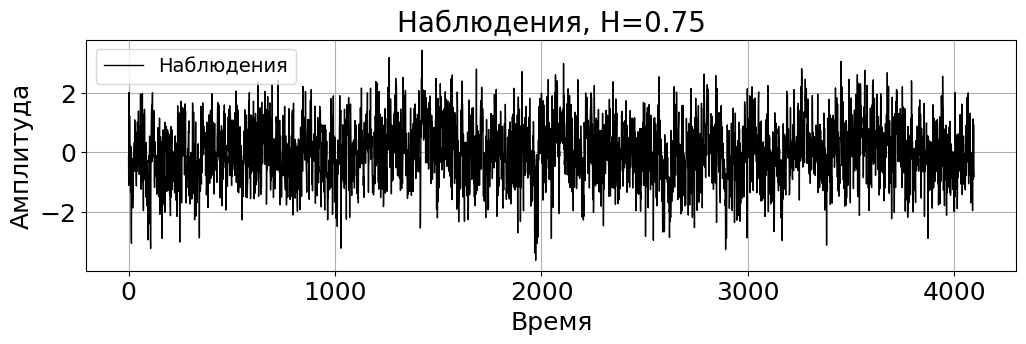

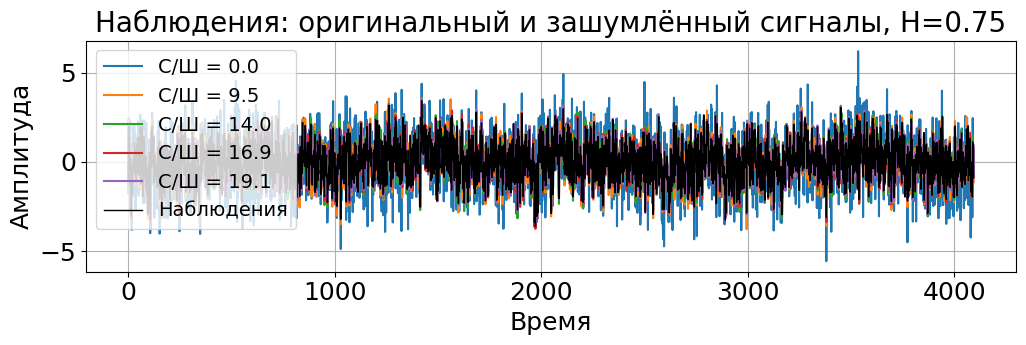

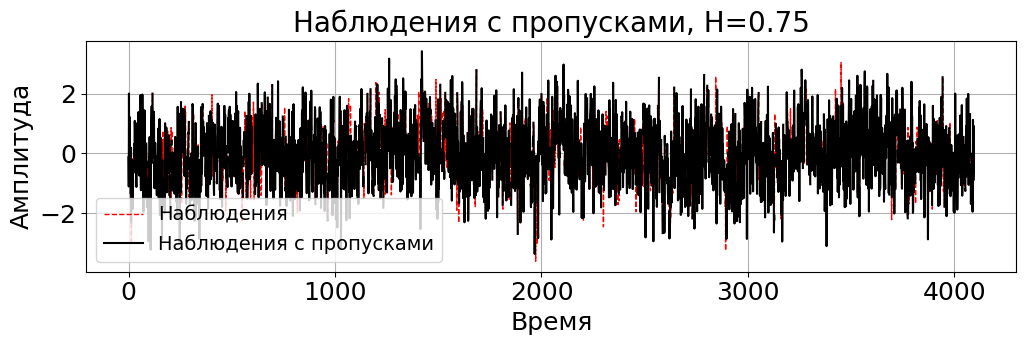

In [8]:
for h in [0.75]:
    plt.figure(figsize=(12, 3))
    generator = ERKasdinGenerator(h, length=TRJ_LEN)
    generated_signal = generator.get_full_sequence()
    gaps_signal, gaps = add_poisson_gaps(generated_signal, 0.1, 1.0)

    plt.plot(generated_signal, label="Наблюдения", color="black", linewidth=1)
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    # plt.xlim(0, 100)
    plt.grid(True)
    plt.title(f"Наблюдения, H={h}", fontdict={"fontsize": 20})
    plt.show()

    plt.figure(figsize=(12, 3))
    for i in range(1, 11, 2):
        noisy_signal, _ = add_noise(generated_signal, ratio=i)
        plt.plot(noisy_signal, label=f"С/Ш = {round(20 * np.log10(i), 1)}")

    plt.plot(generated_signal, label="Наблюдения", color="black", linewidth=1)
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    plt.grid(True)
    # plt.xlim(0, 100)
    plt.title(
        f"Наблюдения: оригинальный и зашумлённый сигналы, H={h}",
        fontdict={"fontsize": 20},
    )
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(
        generated_signal,
        label="Наблюдения",
        color="red",
        linestyle="--",
        linewidth=1,
    )
    plt.plot(gaps_signal, label="Наблюдения с пропусками", color="black")
    plt.xlabel("Время", fontsize=18)
    plt.ylabel("Амплитуда", fontsize=18)
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=18)
    plt.grid(True)
    # plt.xlim(0, 100)
    plt.title(f"Наблюдения с пропусками, H={h}", fontdict={"fontsize": 20})
    plt.show()

## Использование матрицы F n-го порядка для фильтра Калмана

### A

In [9]:
def process_one(i, j, noise_ratio, h, length, n):
    generator = ERKasdinGenerator(h, length=length)
    original_signal = generator.get_full_sequence()
    idx = i * n + j

    noisy_signal, noise = add_noise(original_signal, noise_ratio)
    recovered_Z_0 = recover_signal_by_libkalman(noisy_signal, noise, h, 1, 2, True)
    recovered_Z_1 = recover_signal_by_libkalman(noisy_signal, noise, h, 1, 2, False)
    recovered_Z_2 = recover_signal_by_libkalman(noisy_signal, noise, h, 1, 4, False)
    recovered_Z_3 = recover_signal_by_libkalman(noisy_signal, noise, h, 1, 8, False)
    return (
        idx,
        original_signal,
        noisy_signal,
        recovered_Z_0,
        recovered_Z_1,
        recovered_Z_2,
        recovered_Z_3,
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   36.6s finished


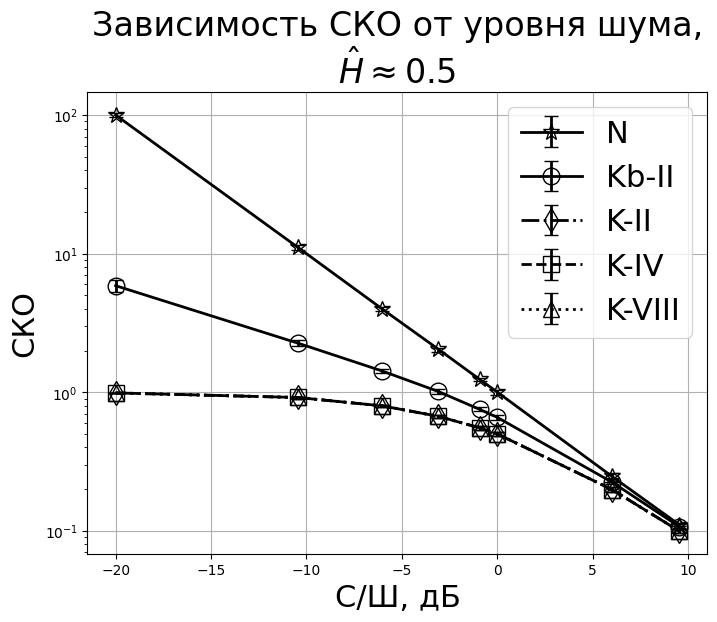

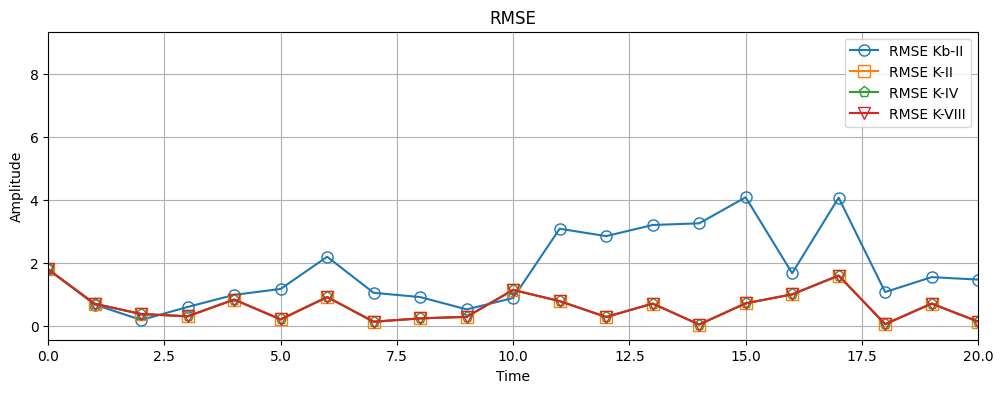

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   45.4s finished


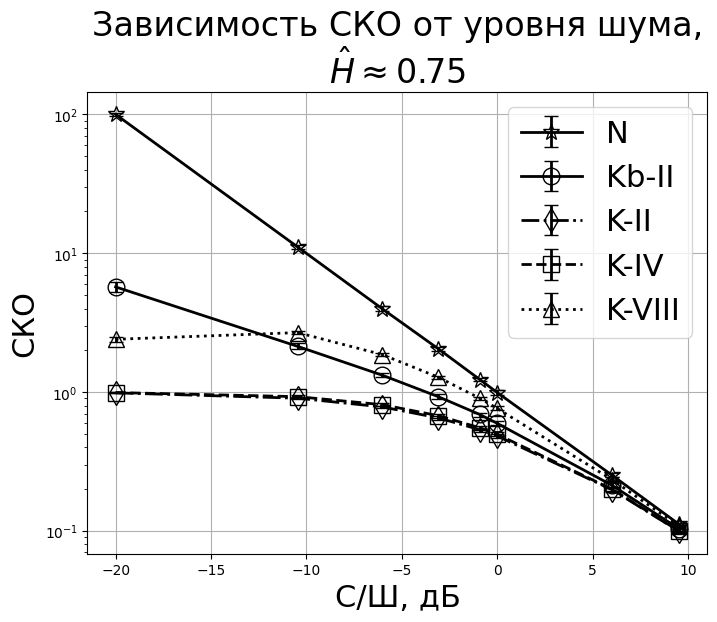

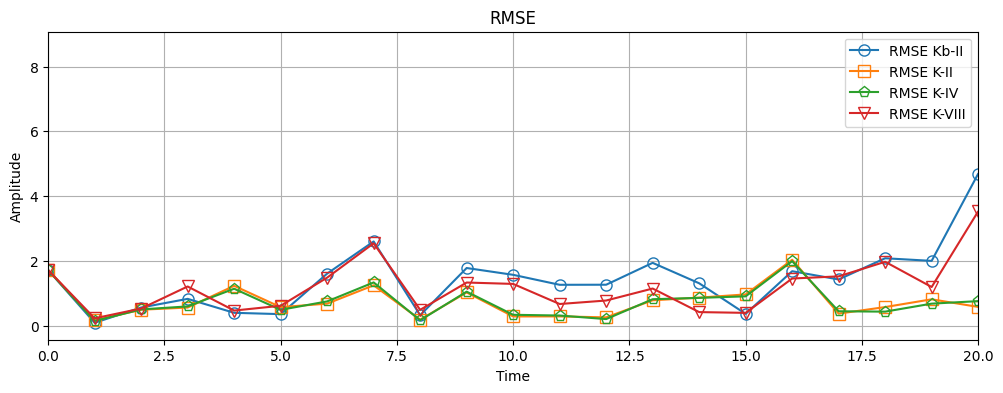

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   50.0s finished


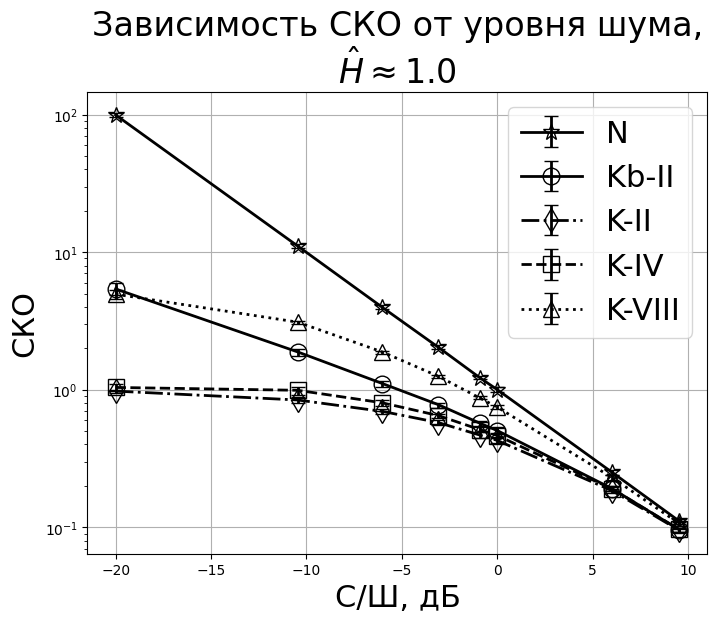

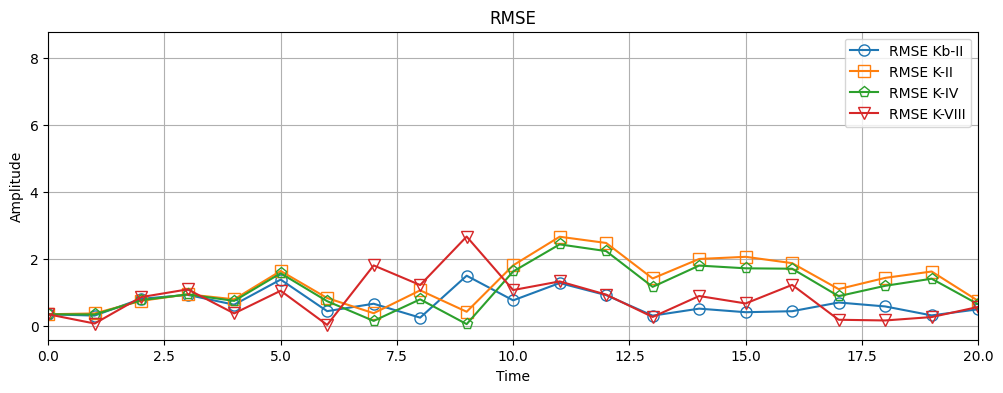

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   56.6s finished


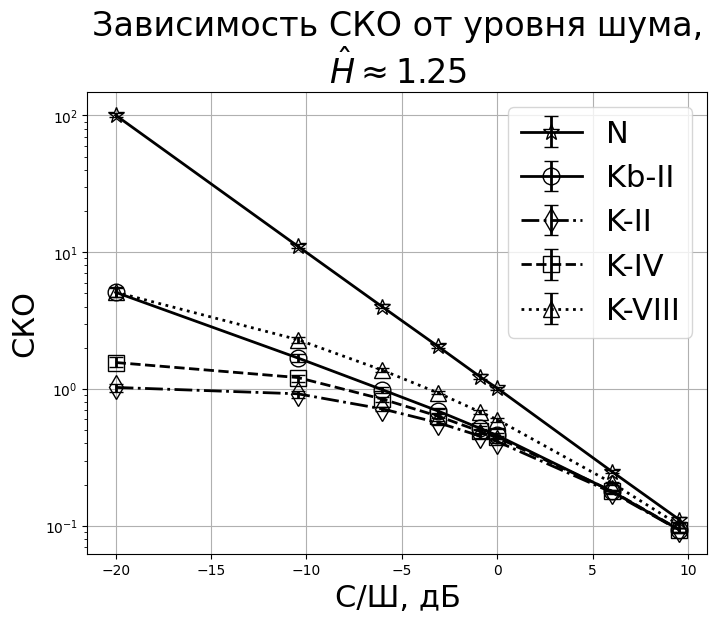

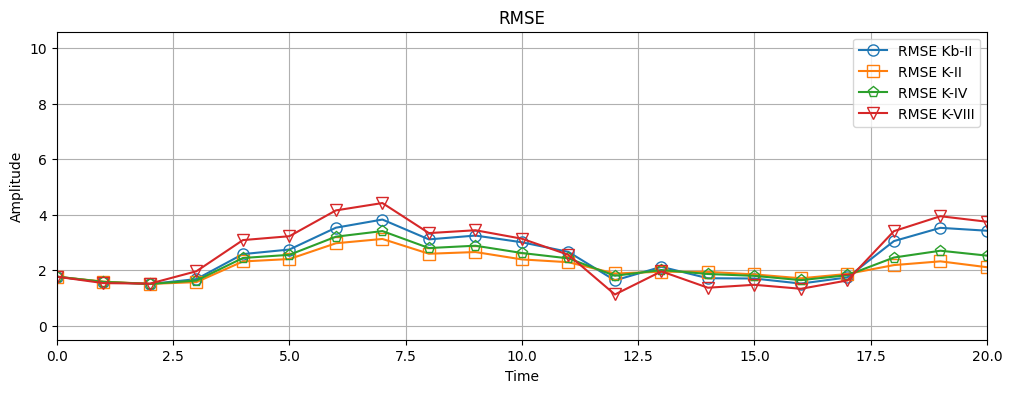

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   49.7s finished


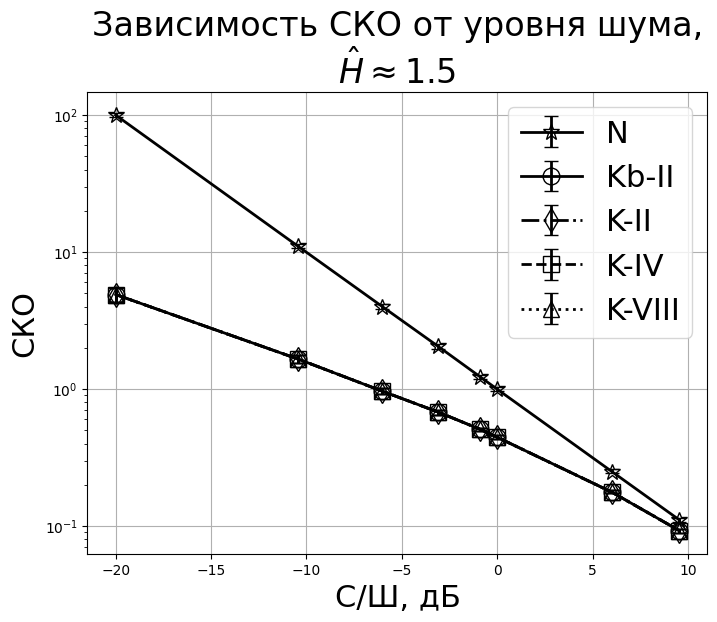

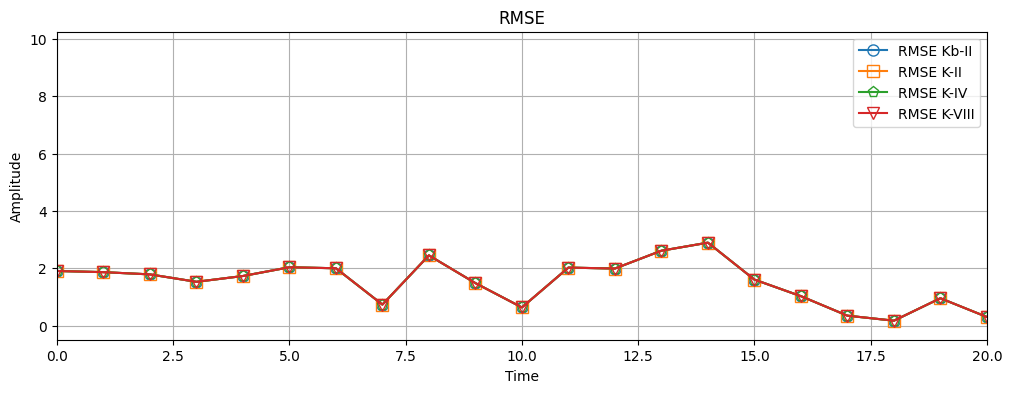

In [10]:
for h in H_LIST:
    noise_ratios = np.array([0.1, 0.3, 0.5, 0.7, 0.9] + list(range(1, 4)))
    n = 50
    snr_db = 20 * np.log10(noise_ratios)
    num_ratios = len(noise_ratios)
    total_signals = n * num_ratios
    tasks = [
        (i, j, noise_ratio, h, TRJ_LEN, n)
        for i, noise_ratio in enumerate(noise_ratios)
        for j in range(n)
    ]

    original_signals_total = np.zeros((total_signals, TRJ_LEN))
    noisy_signals_total = np.zeros((total_signals, TRJ_LEN))
    recovered_0_total = np.zeros((total_signals, TRJ_LEN))
    recovered_1_total = np.zeros((total_signals, TRJ_LEN))
    recovered_2_total = np.zeros((total_signals, TRJ_LEN))
    recovered_3_total = np.zeros((total_signals, TRJ_LEN))

    results = Parallel(
        n_jobs=-1,
        backend="loky",
        verbose=5,
    )(
        delayed(process_one)(i, j, noise_ratio, h, TRJ_LEN, n)
        for i, noise_ratio in enumerate(noise_ratios)
        for j in range(n)
    )

    for idx, original_signal, noisy_signal, r0, r1, r2, r3 in results:
        original_signals_total[idx] = original_signal
        noisy_signals_total[idx] = noisy_signal
        recovered_0_total[idx] = r0
        recovered_1_total[idx] = r1
        recovered_2_total[idx] = r2
        recovered_3_total[idx] = r3

    signals = {
        "N": noisy_signals_total,
        "Kb-II": recovered_0_total,
        "K-II": recovered_1_total,
        "K-IV": recovered_2_total,
        "K-VIII": recovered_3_total,
    }
    mse_df = mse_experiment(
        original_signals_total, signals, noise_ratios, "noise_ratio"
    )
    mse_df["snr"] = 20 * np.log10(mse_df["noise_ratio"])

    styles = {
        "N": dict(marker="*", markersize=12, markerfacecolor="none", color="k"),
        "Kb-II": dict(marker="o", markersize=12, markerfacecolor="none", color="k"),
        "K-II": dict(
            marker="d", markersize=12, markerfacecolor="none", linestyle="-.", color="k"
        ),
        "K-IV": dict(
            marker="s", markersize=12, markerfacecolor="none", linestyle="--", color="k"
        ),
        "K-VIII": dict(
            marker="^", markersize=12, markerfacecolor="none", linestyle=":", color="k"
        ),
    }

    fig, ax = plt.subplots(figsize=(8, 6))
    mseplot(
        data=mse_df,
        x="snr",
        y="mse",
        hue="label",
        styles=styles,
        ax=ax,
        title=f"Зависимость СКО от уровня шума,\n$\\hat{{H}}\\approx${h}",
        linewidth=2,
        capsize=5,
    )
    plot_rmse(original_signals_total, signals)
    plt.show()

### B

In [11]:
def process_one(i, j, gap_rate, length_rate, h, length, n):
    generator = ERKasdinGenerator(h, length=length)
    original_signal = generator.get_full_sequence()
    noise = np.zeros(length)
    idx = i * n + j

    gapped_signal, gaps = add_poisson_gaps(original_signal, gap_rate, length_rate)
    recovered_Z_0 = recover_signal_by_libkalman(gapped_signal, noise, h, 1, 2, True)
    recovered_Z_1 = recover_signal_by_libkalman(gapped_signal, noise, h, 1, 2, False)
    recovered_Z_2 = recover_signal_by_libkalman(gapped_signal, noise, h, 1, 4, False)
    recovered_Z_3 = recover_signal_by_libkalman(gapped_signal, noise, h, 1, 8, False)
    return (
        idx,
        original_signal,
        gapped_signal,
        recovered_Z_0,
        recovered_Z_1,
        recovered_Z_2,
        recovered_Z_3,
    )

In [12]:
gap_rate = 0.1
length_rate = 1.0
n = 50
results = Parallel(
    n_jobs=-1,
    backend="loky",
    verbose=5,
)(
    delayed(process_one)(i, j, h, gap_rate, length_rate, TRJ_LEN, n)
    for i, h in enumerate(H_LIST)
    for j in range(n)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.4s finished


In [13]:
total_signals = n * len(H_LIST)

original_signals_total = np.zeros((total_signals, TRJ_LEN))
gapped_signals_total = np.zeros((total_signals, TRJ_LEN))
recovered_0_total = np.zeros((total_signals, TRJ_LEN))
recovered_1_total = np.zeros((total_signals, TRJ_LEN))
recovered_2_total = np.zeros((total_signals, TRJ_LEN))
recovered_3_total = np.zeros((total_signals, TRJ_LEN))

for idx, original_signal, gapped_signal, r0, r1, r2, r3 in results:
    original_signals_total[idx] = original_signal
    recovered_0_total[idx] = r0
    recovered_1_total[idx] = r1
    recovered_2_total[idx] = r2
    recovered_3_total[idx] = r3

signals = {
    "Kb-II": recovered_0_total,
    "K-II": recovered_1_total,
    "K-IV": recovered_2_total,
    "K-VIII": recovered_3_total,
}

In [14]:
mse_df = mse_experiment(original_signals_total, signals, H_LIST, "h")
mse_df.head()

,h,mse,label,run
0,0.5,0.212900,Kb-II,0
1,0.5,0.223575,Kb-II,1
2,0.5,0.239404,Kb-II,2
3,0.5,0.201655,Kb-II,3
4,0.5,0.242898,Kb-II,4


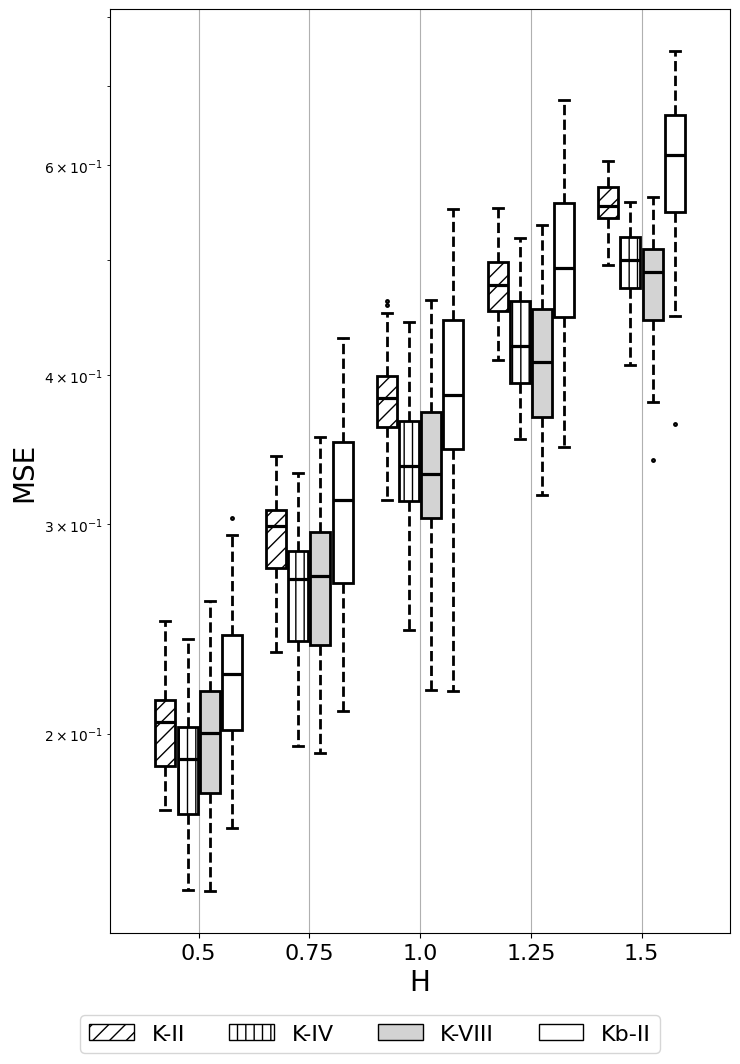

In [15]:
styles = {
    "Kb-II": boxprops_filled(facecolor="white"),
    "K-II": boxprops_filled_hatched(),
    "K-IV": boxprops_filled_hatched(hatch="||"),
    "K-VIII": boxprops_filled(),
}
ax_main = boxplot(
    mse_df,
    "h",
    "mse",
    "label",
    styles=styles,
    y_label="MSE",
    x_label="H",
    y_limits=[],
    fig_size=(8, 12),
)
plt.show()

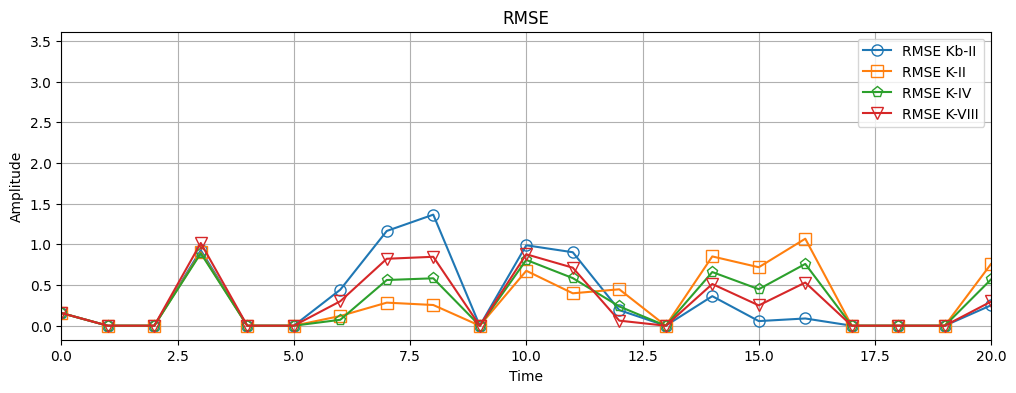

In [16]:
plot_rmse(original_signals_total, signals)